In [20]:
import cv2 
from matplotlib import pyplot as plt

In [21]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import random
import os
import csv
import cv2
from frame import FLCDataset, visualize_transformed_image


In [22]:
train_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc_dataset_train.csv", r"C:\Users\lucyc\Desktop\face_loc_d")
val_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc_dataset_val.csv", r"C:\Users\lucyc\Desktop\face_loc_d")
test_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc_dataset_test.csv", r"C:\Users\lucyc\Desktop\face_loc_d")

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=4)

In [23]:
a, b, c = next(iter(val_loader))

In [24]:
a.shape

torch.Size([128, 3, 24, 24])

In [25]:
def get_args(b):
    return [int(float(x)//1) for x in b.split()]

In [26]:
#visualize_transformed_image(a[6],get_args(b[6]),get_args(b[6]))

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
torch.cuda.empty_cache()

cuda:0


In [28]:
class PNet(nn.Module):

    def __init__(self):
        super(PNet, self).__init__()

        # 定义网络层
        self.conv1 = nn.Conv2d(3, 28, 3)  #24 -> 22 -> maxp -> 11
        self.conv2 = nn.Conv2d(28, 48, 3) #11 -> 9 -> maxp -> 4
        self.conv3 = nn.Conv2d(48, 64, 2) #4 -> 3

        self.linear1 = nn.Linear(64*3*3, 128)

        self.face_det = nn.Linear(128, 2)
        self.bbox = nn.Linear(128, 4)
        self.landmark = nn.Linear(128, 10)

    def forward(self, x):
        # 定义前向传播
        x = F.relu(self.conv1(x)) #22
        x = F.max_pool2d(x, 2) #11
        x = F.relu(self.conv2(x)) #9
        x = F.max_pool2d(x, 2) #4
        x = F.relu(self.conv3(x)) #3

        x = x.view(-1, 64*3*3)
        x = F.relu(self.linear1(x))

        facedet = self.face_det(x)
        bbox = self.bbox(x)
        landmark = self.landmark(x)

        return facedet, bbox, landmark


In [29]:
class PNetLoss(nn.Module):
    def __init__(self):
        super(PNetLoss, self).__init__()
        # 初始化可以在这里完成，如果有必要的话

    def forward(self, facedet, bbox, landmark, label, ltypes):
        # 假设 'device' 是一个全局变量或已经事先定义好的
        loss_total = torch.tensor(0.0, device=device, requires_grad=True)

        face = torch.tensor([1.0, 0.0], device=device)
        not_face = torch.tensor([0.0, 1.0], device=device)
        
        for i, ltype in enumerate(ltypes):
            
            if ltype in ["2", "3", "4"]:
                # 对于类型2，只需要面部检测损失
                # 一个两个元素的tensor
                facedet_loss = F.cross_entropy(facedet[i], not_face)

                loss_total = loss_total + facedet_loss

            elif ltype in ["1", "0"]:
                # 对于类型1和0，计算边界框损失
                facedet_loss = F.cross_entropy(facedet[i], face)

                bbox_loss = F.mse_loss(bbox[i], label[i][:4])

                loss_total = loss_total + (0.5 * bbox_loss + facedet_loss)

            elif ltype == "5":
                # 对于类型3，计算关键点损失
                facedet_loss = F.cross_entropy(facedet[i], face)

                landmark_loss =F.mse_loss(landmark[i], label[i])
                
                loss_total = loss_total + (0.5 * landmark_loss + facedet_loss)

        loss_total = loss_total / len(ltypes)
        #loss_total = loss_total
        return loss_total

In [11]:
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

model = PNet()
print(model)

model.to(device)  # 将模型发送到GPU，如果有的话

# 定义损失函数和优化器
criterion = PNetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


PNet(
  (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(48, 64, kernel_size=(2, 2), stride=(1, 1))
  (linear1): Linear(in_features=576, out_features=128, bias=True)
  (face_det): Linear(in_features=128, out_features=2, bias=True)
  (bbox): Linear(in_features=128, out_features=4, bias=True)
  (landmark): Linear(in_features=128, out_features=10, bias=True)
)


In [12]:
model.train()  # 设置模型为训练模式

train_x = []
train_loss_y = []

train_loss_acc = 0.
train_num = 0

for inputs in train_loader:
    
    img_tensor = inputs[0].to(device)
    label = inputs[1].to(device)
    ltypes = inputs[2]

    facedet, bbox, landmark = model(img_tensor)
    optimizer.zero_grad()  # 清除之前的梯度
    loss = criterion(facedet, bbox, landmark, label, ltypes)
    # 反向传播和优化
    loss.backward()  # 反向传播计算当前的梯度
    optimizer.step()  # 更新参数

    train_loss_acc += loss.item()
    train_num += 1

    train_x.append(train_num)
    train_loss_y.append(loss.item())
    
    print(train_num,loss.item(),sum(train_loss_y[-200:])/200, train_num*128, len(train_dataset))
    

1 52.88041305541992 0.2644020652770996 128 154904
2 51.39371871948242 0.5213706588745117 256 154904
3 56.09688186645508 0.8018550682067871 384 154904
4 57.15610122680664 1.0876355743408204 512 154904
5 55.10307693481445 1.3631509590148925 640 154904
6 57.02231216430664 1.6482625198364258 768 154904
7 56.18067169189453 1.9291658782958985 896 154904
8 64.7979507446289 2.253155632019043 1024 154904
9 58.47063064575195 2.5455087852478027 1152 154904
10 61.22749710083008 2.851646270751953 1280 154904
11 68.1937255859375 3.1926148986816405 1408 154904
12 61.29696273803711 3.499099712371826 1536 154904
13 52.17562484741211 3.7599778366088867 1664 154904
14 58.381805419921875 4.051886863708496 1792 154904
15 48.32994079589844 4.293536567687989 1920 154904
16 65.00406646728516 4.618556900024414 2048 154904
17 66.89064025878906 4.953010101318359 2176 154904
18 53.66822052001953 5.221351203918457 2304 154904
19 57.3259162902832 5.507980785369873 2432 154904
20 59.5102653503418 5.805532112121582 2

In [ ]:
# 验证多任务训练在 单一任务上的表现 是否有提升
# 人脸平均绝对值误差 单任务        全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 8.135152058410645
# 人脸平均绝对值误差 均方差 多任务 全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 8.84007318687439
# 人脸交叉熵损失  单任务          全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 11.208772300338746
# 人脸交叉熵损失 均方差  多任务   全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 13.04701942062378

In [13]:

criterion = PNetLoss()

model.eval() 
val_loss_acc = 0
val_num = 0
with torch.no_grad():
    for inputs in val_loader:
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        loss = criterion(facedet, bbox, landmark, label, ltypes)

        val_loss_acc += loss.item()
        val_num += 1

        print(val_num,loss.item(),val_loss_acc/val_num, val_num*32, len(val_dataset))

print("val loss avg:", val_loss_acc/val_num)


1 3.14139723777771 3.14139723777771 32 12908
2 4.5008463859558105 3.8211218118667603 64 12908
3 4.477199077606201 4.039814233779907 96 12908
4 3.4712395668029785 3.897670567035675 128 12908
5 2.218735933303833 3.561883640289307 160 12908
6 2.968477725982666 3.462982654571533 192 12908
7 3.181561231613159 3.4227795941489085 224 12908
8 3.8573954105377197 3.4771065711975098 256 12908
9 3.8265023231506348 3.5159283214145236 288 12908
10 3.8760342597961426 3.5519389152526855 320 12908
11 3.7486095428466797 3.569818063215776 352 12908
12 3.893951654434204 3.5968291958173118 384 12908
13 4.837599277496338 3.69227304825416 416 12908
14 3.392993927001953 3.6708959681647166 448 12908
15 4.422684192657471 3.7210151831309 480 12908
16 4.841810703277588 3.791064903140068 512 12908
17 2.8877625465393066 3.737929470398847 544 12908
18 3.2638678550720215 3.711592713991801 576 12908
19 4.976240158081055 3.778153105785972 608 12908
20 3.750124454498291 3.7767516732215882 640 12908
21 3.7103657722473145

In [1]:
# draw loss curve
plt.plot(train_x, train_loss_y, label='train')
plt.xlabel('num')
plt.ylabel('loss')
plt.title('Training loss')
plt.show()



NameError: name 'plt' is not defined

In [30]:
# 保存模型
torch.save(model, 'face_loc_r_1_NN.pth')

NameError: name 'model' is not defined

In [47]:
# load model
model_trained = torch.load('face_loc_r_1_t.pth')
model_trained.eval()  # 设置模型为评估/测试模式


PNet(
  (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(48, 64, kernel_size=(2, 2), stride=(1, 1))
  (linear1): Linear(in_features=576, out_features=128, bias=True)
  (face_det): Linear(in_features=128, out_features=2, bias=True)
  (bbox): Linear(in_features=128, out_features=4, bias=True)
  (landmark): Linear(in_features=128, out_features=10, bias=True)
)

In [48]:
aa = iter(test_loader)

In [49]:

a, b, c = next(aa)

In [50]:
def get_argsn(b):
    return [int(float(x)//1) for x in b]

def is_face(i):
    if i == "0":
        return "face"
    if i == "1":
        return "face"
    if i == "2":
        return "not face"
    if i == "3":
        return "not face"
    if i == "4":
        return "not face"
    if i == "5":
        return "face"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


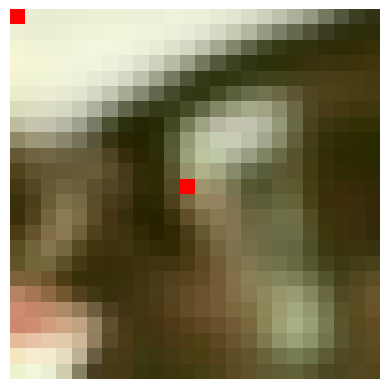

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


not face
tensor([[-5.1209, -5.2404]], device='cuda:0')
tensor([[ 1.6209,  0.2531, 20.6698, 25.5285]], device='cuda:0')
tensor([[ 6.5705,  8.2938, 14.8708,  8.2830, 10.9772, 13.6347,  7.2509, 17.5701,
         14.8515, 17.3171]], device='cuda:0')
not face


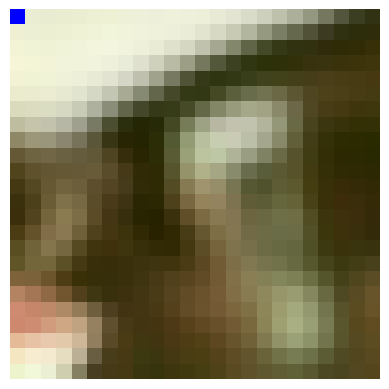

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


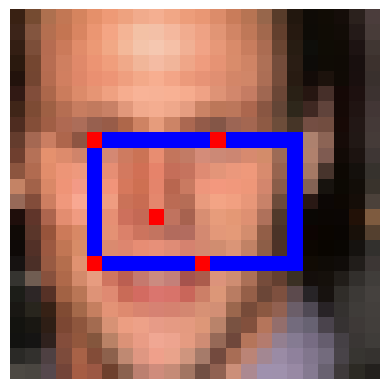

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


face
tensor([[-3.3761, -5.9197]], device='cuda:0')
tensor([[ 0.1587, -0.2637, 17.8805, 22.1973]], device='cuda:0')
tensor([[ 5.7422,  7.4135, 13.2153,  7.3612,  9.1282, 12.0277,  6.0733, 15.1405,
         12.4536, 15.3980]], device='cuda:0')
face


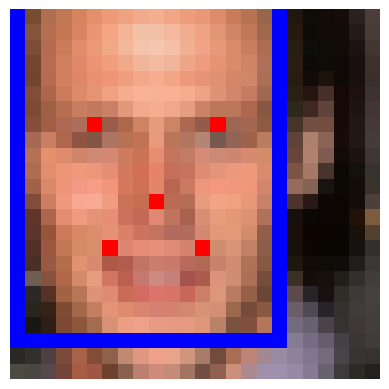

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


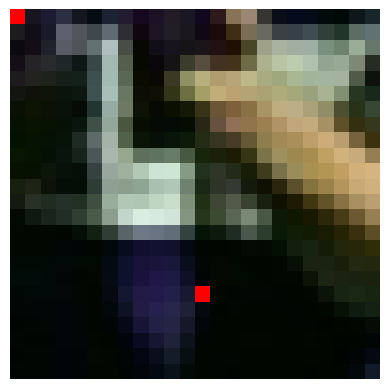

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


not face
tensor([[-6.5464, -3.5329]], device='cuda:0')
tensor([[ 2.6812, -0.1700, 20.4391, 24.6713]], device='cuda:0')
tensor([[ 6.4946,  7.7690, 14.2766,  7.8620, 11.2114, 13.6077,  7.2740, 17.7390,
         14.7529, 17.1330]], device='cuda:0')
not face


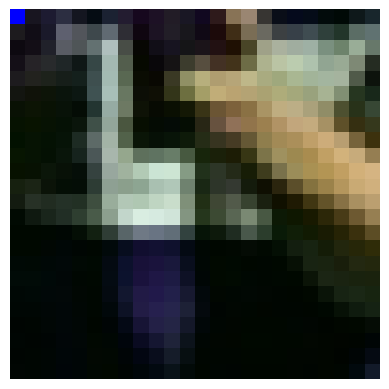

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


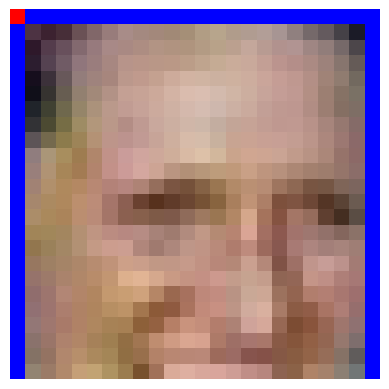

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


face
tensor([[-4.2776, -6.1960]], device='cuda:0')
tensor([[ 0.7020, -0.1088, 20.3734, 25.1605]], device='cuda:0')
tensor([[ 6.5253,  8.3559, 14.8813,  8.3664, 10.4621, 13.4285,  6.9539, 17.1909,
         14.3820, 17.2637]], device='cuda:0')
face


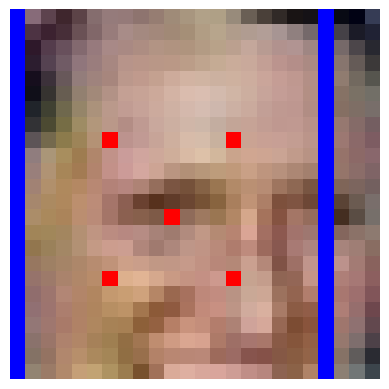

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


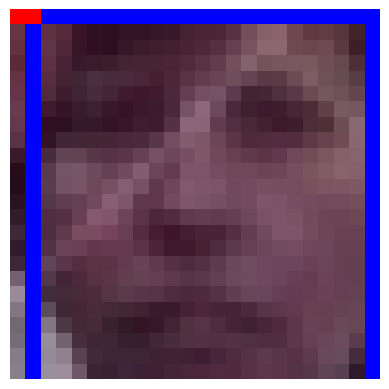

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


face
tensor([[-4.7791, -5.4100]], device='cuda:0')
tensor([[ 1.4032, -0.1670, 20.2148, 24.7509]], device='cuda:0')
tensor([[ 6.4336,  8.0203, 14.4929,  8.0697, 10.5678, 13.2459,  6.9805, 17.0411,
         14.4299, 17.0055]], device='cuda:0')
not face


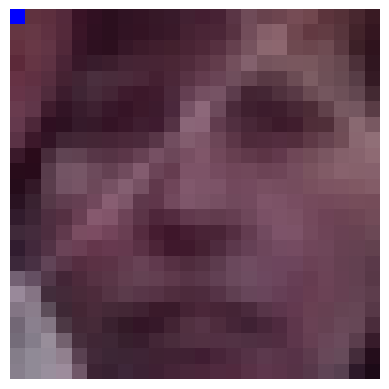

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


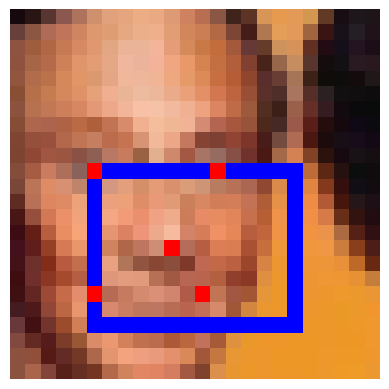

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


face
tensor([[-3.5211, -5.8527]], device='cuda:0')
tensor([[ 0.3784, -0.1287, 18.1807, 22.6284]], device='cuda:0')
tensor([[ 5.8413,  7.5369, 13.4027,  7.5146,  9.3760, 12.2030,  6.1954, 15.4379,
         12.7527, 15.6235]], device='cuda:0')
face


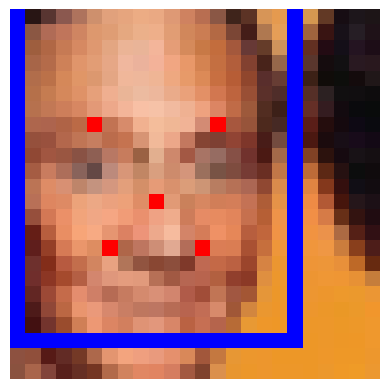

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


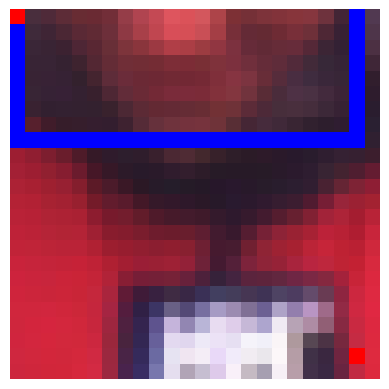

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


face
tensor([[-5.0090, -5.3744]], device='cuda:0')
tensor([[ 0.8930, -0.1788, 20.4246, 25.1105]], device='cuda:0')
tensor([[ 6.4441,  8.0727, 14.7167,  8.1242, 10.7383, 13.5318,  6.9808, 17.4052,
         14.4578, 17.3623]], device='cuda:0')
not face


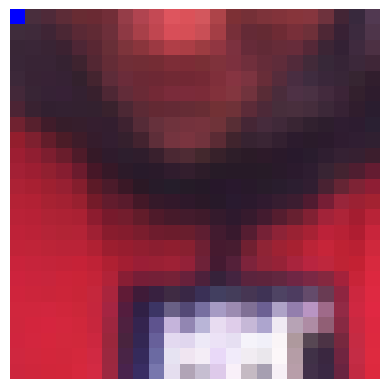

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


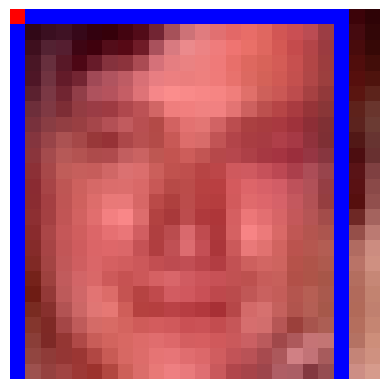

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


face
tensor([[-3.3665, -5.8492]], device='cuda:0')
tensor([[ 0.7097, -0.2986, 17.9388, 22.1599]], device='cuda:0')
tensor([[ 5.8334,  7.4332, 13.1934,  7.4167,  9.2128, 11.9854,  6.2418, 15.0660,
         12.6907, 15.3030]], device='cuda:0')
face


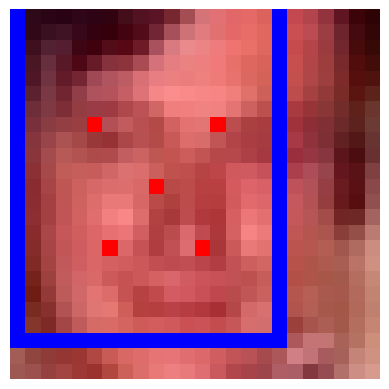

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


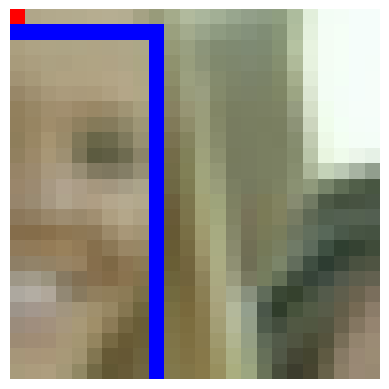

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


face
tensor([[-3.8690, -4.8536]], device='cuda:0')
tensor([[ 0.4663, -0.1607, 17.1611, 21.1071]], device='cuda:0')
tensor([[ 5.4512,  6.9161, 12.4519,  6.9187,  8.7867, 11.2403,  5.7093, 14.5213,
         12.0323, 14.5507]], device='cuda:0')
not face


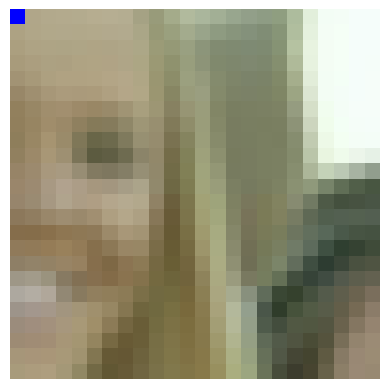

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


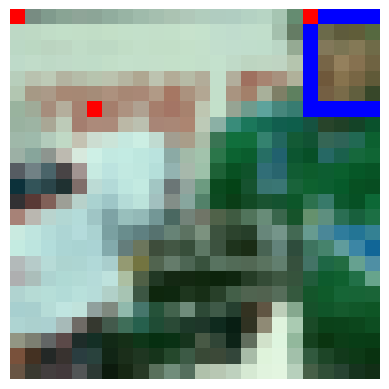

not face
tensor([[-6.0739, -3.8654]], device='cuda:0')
tensor([[ 1.4119, -0.0519, 19.8833, 24.2235]], device='cuda:0')
tensor([[ 6.2029,  7.5733, 13.9876,  7.8244, 10.6908, 13.1493,  6.7025, 17.3341,
         14.0486, 16.8608]], device='cuda:0')
not face


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


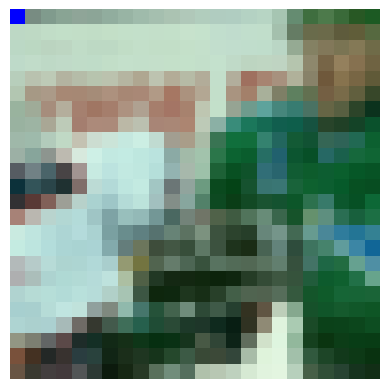

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


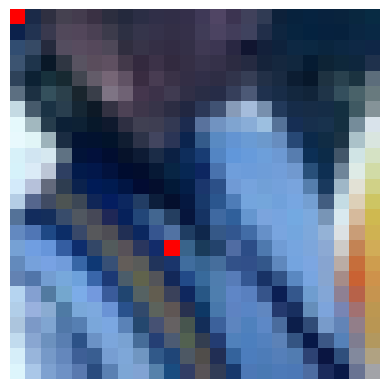

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


not face
tensor([[-6.8439, -3.3253]], device='cuda:0')
tensor([[ 2.1402,  0.1372, 20.6626, 25.1955]], device='cuda:0')
tensor([[ 6.4665,  7.7832, 14.4301,  7.9954, 11.4277, 13.6234,  7.1006, 18.0672,
         14.8987, 17.3429]], device='cuda:0')
not face


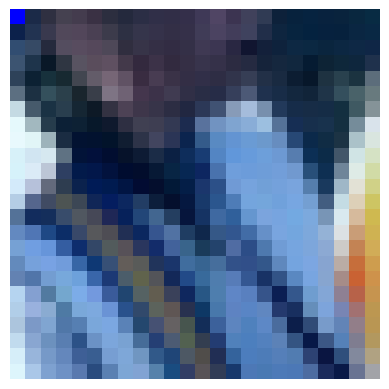

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


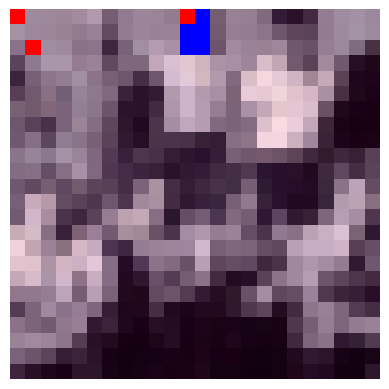

not face
tensor([[-5.8058, -3.0976]], device='cuda:0')
tensor([[ 1.7543, -0.0249, 18.0405, 21.9565]], device='cuda:0')
tensor([[ 5.6745,  6.8406, 12.6569,  7.0023,  9.9727, 12.0170,  6.1632, 15.7453,
         12.9043, 15.2247]], device='cuda:0')
not face


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


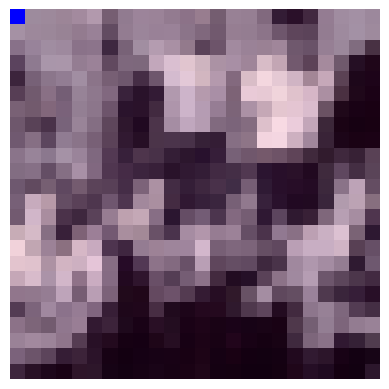

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


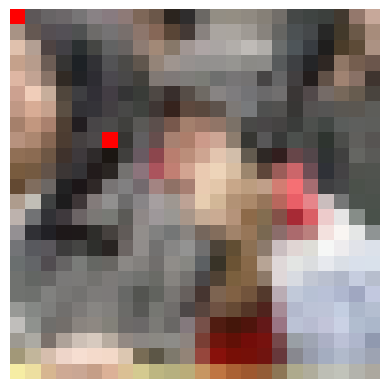

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


not face
tensor([[-4.9802, -4.9273]], device='cuda:0')
tensor([[ 1.5833, -0.0846, 19.6414, 24.1239]], device='cuda:0')
tensor([[ 6.3289,  7.8158, 14.1148,  7.8803, 10.4598, 13.0063,  6.8661, 16.7745,
         14.0777, 16.5999]], device='cuda:0')
not face


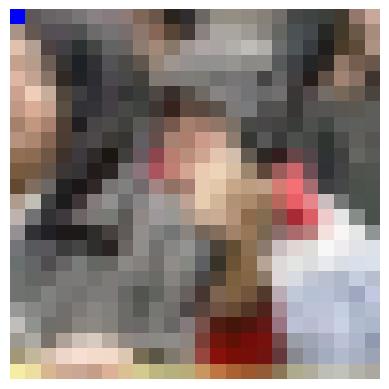

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


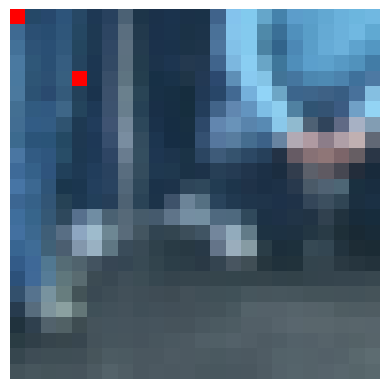

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


not face
tensor([[-5.9011, -3.3915]], device='cuda:0')
tensor([[ 1.5855,  0.5161, 18.6401, 23.0429]], device='cuda:0')
tensor([[ 5.8112,  7.2320, 13.1692,  7.2761, 10.2856, 12.3208,  6.3606, 16.2674,
         13.3676, 15.6495]], device='cuda:0')
not face


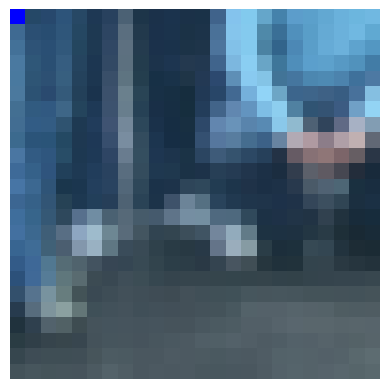

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


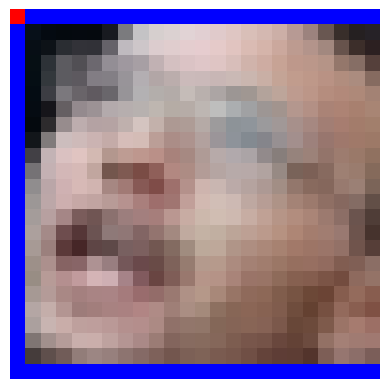

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


face
tensor([[-4.6996, -5.7574]], device='cuda:0')
tensor([[ 1.3925, -0.0321, 20.6332, 25.4650]], device='cuda:0')
tensor([[ 6.6617,  8.4089, 14.9529,  8.4033, 10.7700, 13.5603,  7.1698, 17.4426,
         14.7564, 17.4512]], device='cuda:0')
face


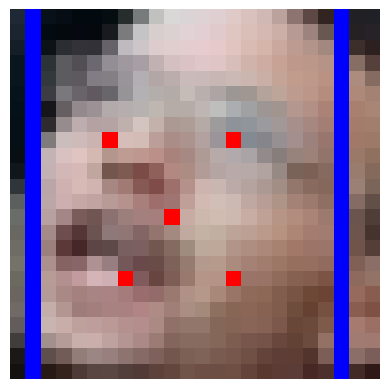

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


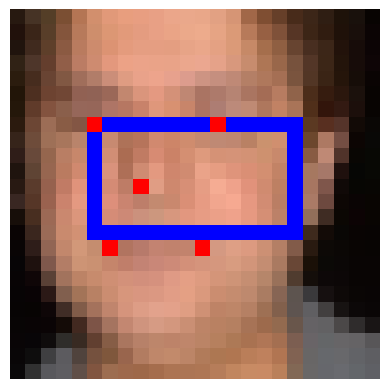

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


face
tensor([[-3.5648, -6.2225]], device='cuda:0')
tensor([[ 0.5163, -0.4430, 18.9310, 23.3565]], device='cuda:0')
tensor([[ 6.1368,  7.8294, 13.9729,  7.8132,  9.6330, 12.6035,  6.5249, 15.8957,
         13.3120, 16.2463]], device='cuda:0')
face


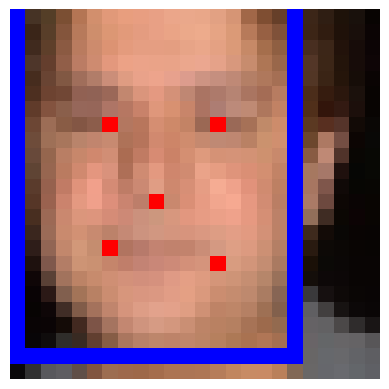

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


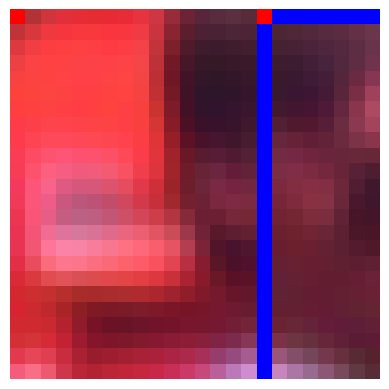

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


face
tensor([[-4.0018, -5.8811]], device='cuda:0')
tensor([[ 0.1759, -0.0478, 19.1880, 23.8711]], device='cuda:0')
tensor([[ 6.0613,  7.8867, 14.1030,  7.8024,  9.9182, 12.8645,  6.4827, 16.3741,
         13.3345, 16.5172]], device='cuda:0')
face


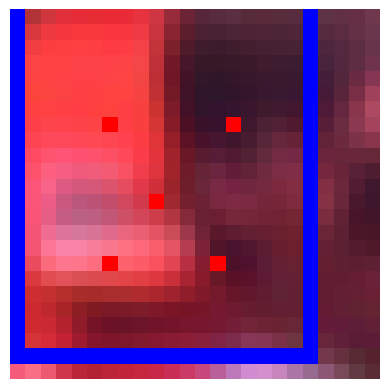

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


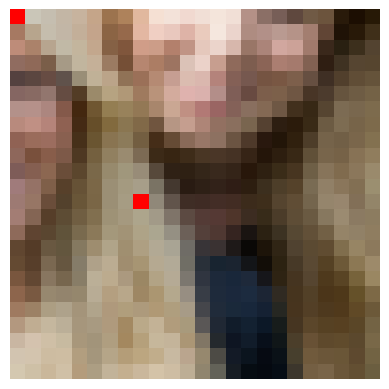

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


not face
tensor([[-4.5936, -4.3287]], device='cuda:0')
tensor([[ 0.5366, -0.0569, 17.7751, 21.9064]], device='cuda:0')
tensor([[ 5.5738,  6.9889, 12.8189,  7.0282,  9.3959, 11.8318,  5.9315, 15.3244,
         12.4523, 15.2337]], device='cuda:0')
not face


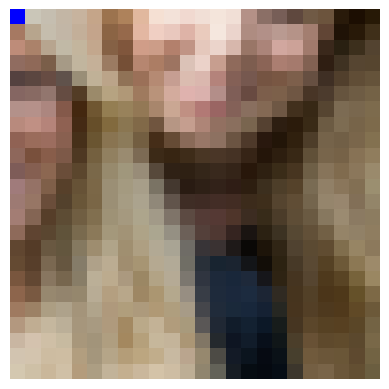

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


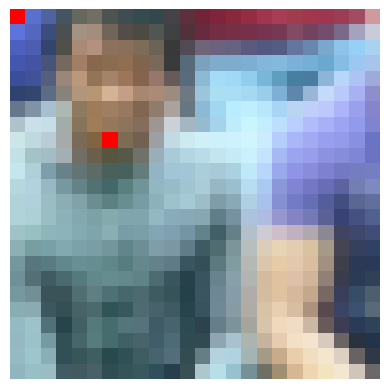

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


not face
tensor([[-5.8806, -4.1681]], device='cuda:0')
tensor([[ 1.0490,  0.2671, 20.0070, 24.7759]], device='cuda:0')
tensor([[ 6.3738,  7.8224, 14.3302,  8.0305, 10.8362, 13.2275,  6.7056, 17.4527,
         14.2382, 17.0044]], device='cuda:0')
not face


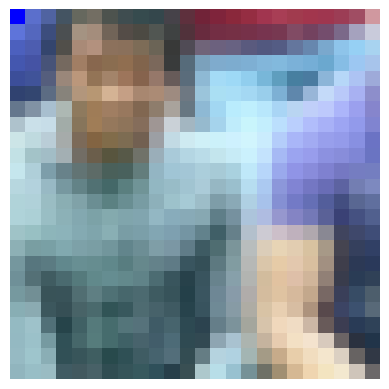

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


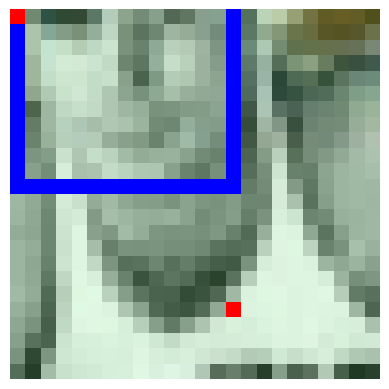

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


face
tensor([[-5.1991, -3.5963]], device='cuda:0')
tensor([[ 1.4667, -0.0312, 17.6071, 21.5340]], device='cuda:0')
tensor([[ 5.5792,  6.8404, 12.5252,  6.9221,  9.4984, 11.6491,  6.0195, 15.2991,
         12.5336, 14.9470]], device='cuda:0')
not face


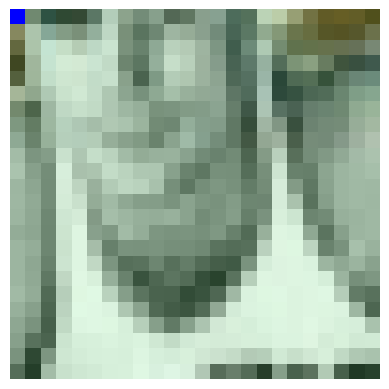

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


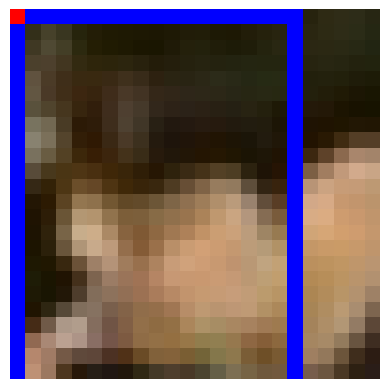

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


face
tensor([[-4.6950, -5.7555]], device='cuda:0')
tensor([[ 1.1726,  0.5135, 20.4972, 25.6868]], device='cuda:0')
tensor([[ 6.5344,  8.4831, 14.9786,  8.3417, 10.9257, 13.6568,  7.0974, 17.4648,
         14.6838, 17.3189]], device='cuda:0')
face


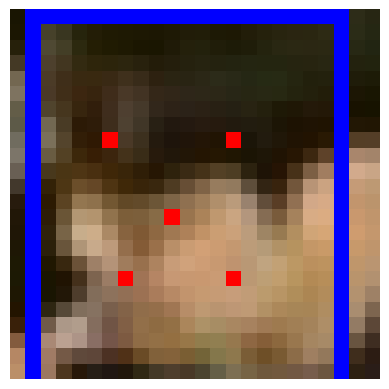

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


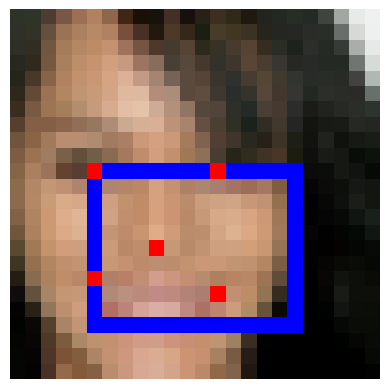

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


face
tensor([[-3.7708, -5.8475]], device='cuda:0')
tensor([[-0.1998,  0.3911, 18.4015, 23.2747]], device='cuda:0')
tensor([[ 5.7787,  7.7343, 13.6416,  7.5098,  9.5100, 12.3278,  6.0851, 15.7689,
         12.7739, 15.8264]], device='cuda:0')
face


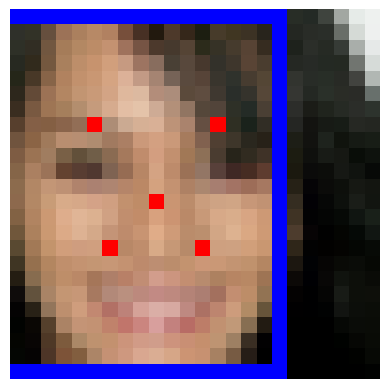

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


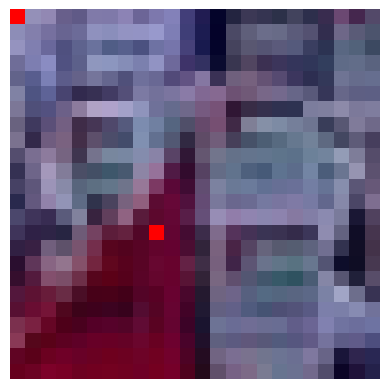

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


not face
tensor([[-5.6798, -4.0513]], device='cuda:0')
tensor([[ 1.7461,  0.2960, 19.3614, 23.8683]], device='cuda:0')
tensor([[ 6.0781,  7.6418, 13.7903,  7.5906, 10.5085, 12.8133,  6.6770, 16.7433,
         13.8409, 16.3102]], device='cuda:0')
not face


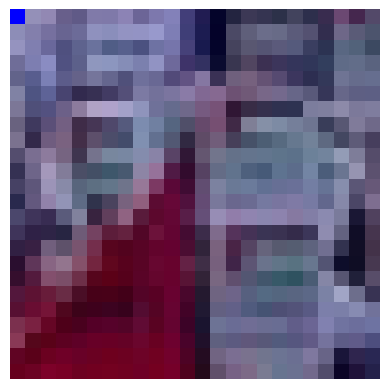

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


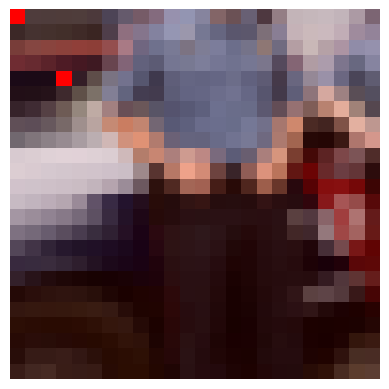

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


not face
tensor([[-5.5737, -4.3544]], device='cuda:0')
tensor([[ 1.5675, -0.3093, 19.7487, 23.9601]], device='cuda:0')
tensor([[ 6.1791,  7.5391, 13.9513,  7.8114, 10.5490, 13.0428,  6.8379, 16.9634,
         13.9736, 16.6823]], device='cuda:0')
not face


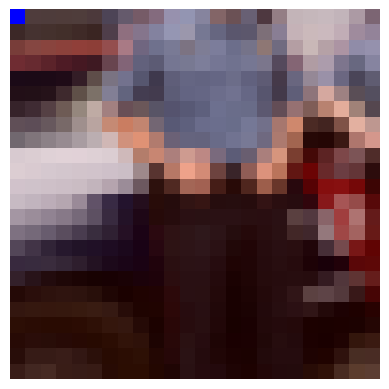

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


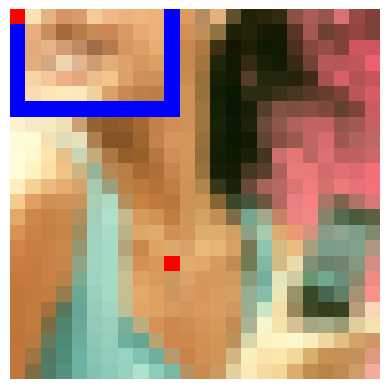

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


not face
tensor([[-4.3033, -5.4920]], device='cuda:0')
tensor([[ 0.3375,  0.1443, 18.9902, 23.8242]], device='cuda:0')
tensor([[ 6.0200,  7.8211, 13.9860,  7.7591,  9.9849, 12.7240,  6.3962, 16.3558,
         13.3075, 16.3901]], device='cuda:0')
face


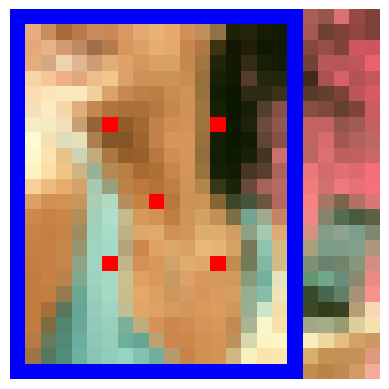

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


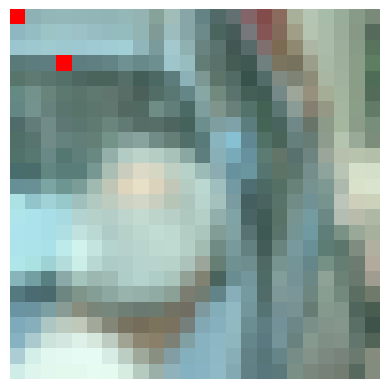

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


not face
tensor([[-5.3252, -3.6187]], device='cuda:0')
tensor([[ 1.4020,  0.1568, 17.7334, 21.8050]], device='cuda:0')
tensor([[ 5.5648,  6.9488, 12.5679,  7.0284,  9.5841, 11.7235,  6.0104, 15.4289,
         12.6108, 14.9954]], device='cuda:0')
not face


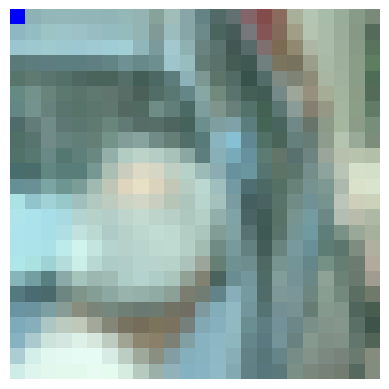

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


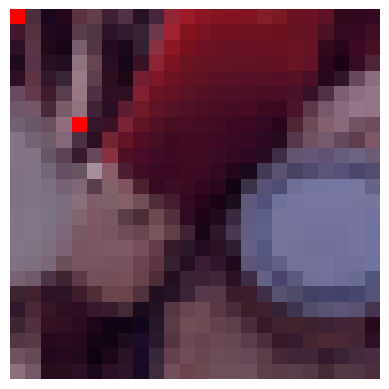

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


not face
tensor([[-5.3478, -4.7091]], device='cuda:0')
tensor([[ 1.1368, -0.0704, 20.0395, 24.5962]], device='cuda:0')
tensor([[ 6.3286,  7.8533, 14.3208,  7.8787, 10.6705, 13.2830,  6.8170, 17.2041,
         14.2161, 17.0254]], device='cuda:0')
not face


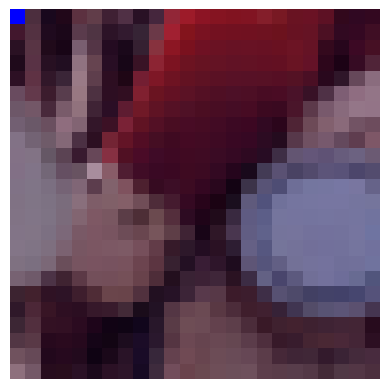

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


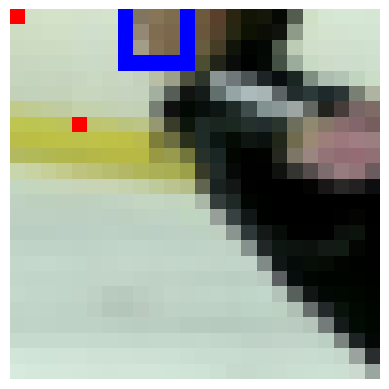

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


not face
tensor([[-5.1245, -4.0515]], device='cuda:0')
tensor([[ 0.2926,  0.6928, 17.9302, 22.6536]], device='cuda:0')
tensor([[ 5.5359,  7.2222, 12.9466,  7.1128,  9.7255, 12.0763,  5.9020, 15.8835,
         12.4874, 15.4222]], device='cuda:0')
not face


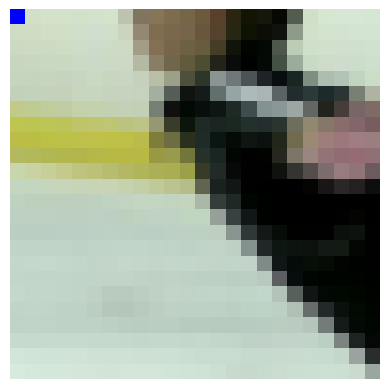

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


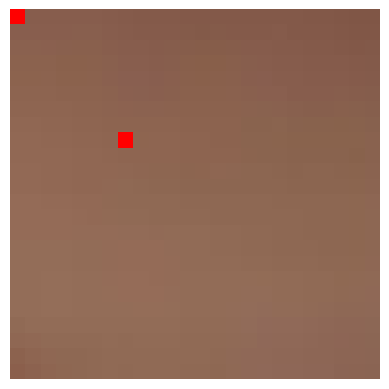

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


not face
tensor([[-3.3302, -5.6627]], device='cuda:0')
tensor([[ 0.5028, -0.4203, 17.5978, 21.5452]], device='cuda:0')
tensor([[ 5.6533,  7.1802, 12.8636,  7.1622,  8.8015, 11.4502,  5.9647, 14.5682,
         12.3989, 14.8879]], device='cuda:0')
face


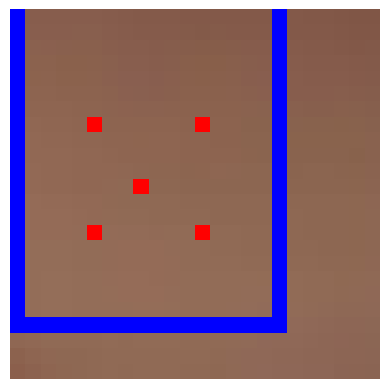

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


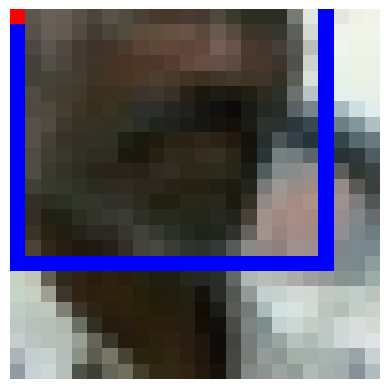

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


face
tensor([[-5.3059, -4.0926]], device='cuda:0')
tensor([[ 1.4485, -0.0244, 18.9163, 23.1663]], device='cuda:0')
tensor([[ 5.9869,  7.3280, 13.4250,  7.4535, 10.2371, 12.5441,  6.5000, 16.3185,
         13.5246, 15.9847]], device='cuda:0')
not face


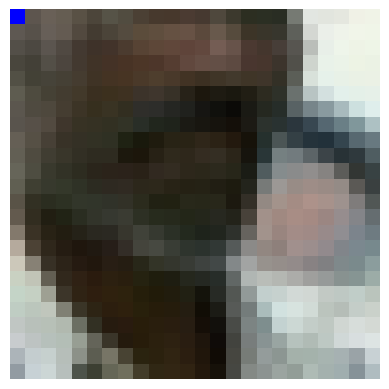

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


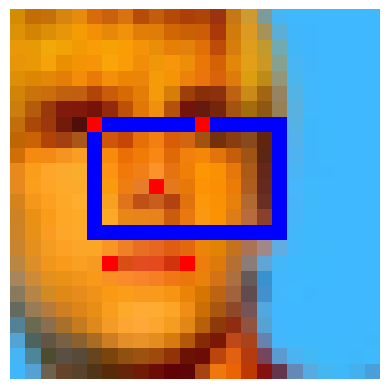

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


face
tensor([[-3.9981, -5.9168]], device='cuda:0')
tensor([[-0.2053,  0.0562, 18.9377, 23.8189]], device='cuda:0')
tensor([[ 6.0105,  7.8926, 14.0922,  7.7293,  9.8773, 12.8352,  6.3136, 16.3434,
         13.1511, 16.4197]], device='cuda:0')
face


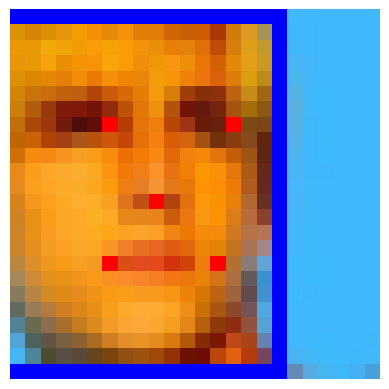

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


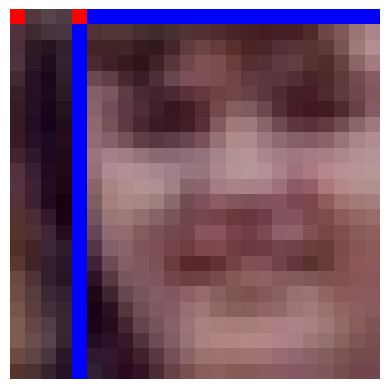

face
tensor([[-4.6673, -5.6790]], device='cuda:0')
tensor([[ 1.6838, -0.2510, 20.4108, 25.0166]], device='cuda:0')
tensor([[ 6.5744,  8.2216, 14.7311,  8.2140, 10.6927, 13.4553,  7.1790, 17.1693,
         14.6571, 17.2111]], device='cuda:0')
face


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


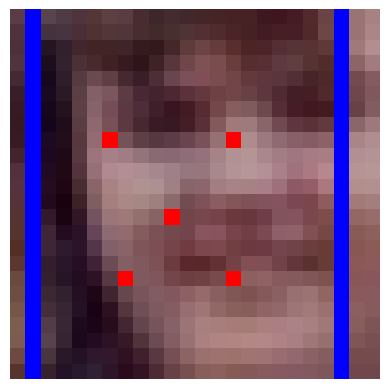

total: 32
right: 13
accuracy: 0.1015625


In [54]:
right = 0
total = 0
for i in range(32):

    visualize_transformed_image(a[i],get_argsn(b[i]),get_argsn(b[i]))
    print(is_face(c[i]))

    with torch.no_grad():
        face_det, bbox, landmark = model_trained(a[i].to(device))
    print(face_det)
    print(bbox)
    print(landmark)

    if face_det[0][0] - face_det[0][1] > 1:
        print("face")
        visualize_transformed_image(a[i],get_argsn(bbox[0]),get_argsn(landmark[0]))   
    else:
        print("not face")
        visualize_transformed_image(a[i],[0,0,0,0],None)
    
    if face_det[0][0] - face_det[0][1] > 1 and is_face(c[i]) == "face":
        right += 1
    if face_det[0][0] - face_det[0][1] > 1 and is_face(c[i]) == "not face":
        right += 1

    total += 1

print("total: {}".format(total))
print("right: {}".format(right))
print("accuracy: {}".format(right/128))

In [ ]:
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

model = PNet()
print(model)

model.to(device)  # 将模型发送到GPU，如果有的话

# 定义损失函数和优化器
criterion = PNetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 训练模型
num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式

    train_x = []
    train_loss_y = []

    train_loss_acc = 0.
    train_num = 0

    for inputs in train_loader:
        
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        optimizer.zero_grad()  # 清除之前的梯度
        loss = criterion(facedet, bbox, landmark, label, ltypes)
        # 反向传播和优化
        loss.backward()  # 反向传播计算当前的梯度
        optimizer.step()  # 更新参数

        train_loss_acc += loss.item()
        train_num += 1

        train_x.append(train_num)
        train_loss_y.append(loss.item())
        print(train_num,loss.item(),sum(train_loss_y[-200:])/200, train_num*32, len(train_dataset))

    model.eval() 
    val_loss_acc = 0
    val_num = 0
    with torch.no_grad():
        for inputs in val_loader:
            img_tensor = inputs[0].to(device)
            label = inputs[1].to(device)
            ltypes = inputs[2]

            facedet, bbox, landmark = model(img_tensor)
            loss = criterion(facedet, bbox, landmark, label, ltypes)

            val_loss_acc += loss.item()
            val_num += 1

            print(val_num,loss.item(),val_loss_acc/val_num, val_num*32, len(train_dataset))

    print("Epoch [{}/{}], Loss: {:.2f}, Val_loss: {:.2f}".format(epoch+1, num_epochs, val_loss_acc/val_num, val_loss_acc/val_num))

    # draw loss curve
    plt.plot(train_x, train_loss_y, label='train')
    plt.xlabel('num')
    plt.ylabel('loss')
    plt.title('Training loss')
    plt.show()
    
    input("Press Enter to continue...")
